In [ ]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"  
path = "/gpfs/data1/lianggp/lir/solar_data/code/SolarSat"
os.chdir(path)
print("Directory changed to:", os.getcwd())


: 

In [ ]:
# Check TensorFlow version
print(tf.__version__)

# Check for GPU availability
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))


: 

In [30]:
import numpy as np
import os
import matplotlib.pyplot as plt
from tensorflow import keras
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger
from tensorflow.keras import layers, models

In [3]:
data = np.load('solarsat_point_train.npz', allow_pickle=True)
x_train = data['arr_0']
y_train = data['arr_1']
df_train = data['arr_2']
data = np.load('solarsat_point_test.npz', allow_pickle=True)
x_test = data['arr_0']
y_test = data['arr_1']
df_test = data['arr_2']

x_test=np.transpose(x_test[:,0,:,:], (0,2,1))
y_test=np.transpose(y_test[:,0,:,:], (0,2,1))
x_train=np.transpose(x_train[:,0,:,:], (0,2,1))
y_train=np.transpose(y_train[:,0,:,:], (0,2,1))

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, random_state=42)
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape, x_val.shape, y_val.shape)

(22531, 8, 5) (22531, 12, 1) (8608, 8, 5) (8608, 12, 1) (2504, 8, 5) (2504, 12, 1)


In [4]:
# Callbacks
checkpoint = ModelCheckpoint('best_lstm_model.h5', monitor='val_loss', save_best_only=True, mode='min')
csv_logger = CSVLogger('training_log.csv', append=True)

callbacks_list = [checkpoint, csv_logger]

In [26]:
from tensorflow.keras import layers
def build_lstm_model():
    # Input layer: Expect input shape (8, 5), where 8 is the number of time steps and 5 is the number of features per time step.
    inputs = keras.Input(shape=(8, 5))

    # LSTM layer: Let's assume we use 50 units and want to keep the sequence
    x = layers.LSTM(50, return_sequences=False)(inputs)

    # Repeat the context vector to match the desired output time steps (12)
    x = layers.RepeatVector(12)(x)

    # LSTM layer: Return sequences for the repeated context vector
    x = layers.LSTM(50, return_sequences=True)(x)

    # TimeDistributed Dense layer to project the output to the desired feature dimension (1)
    outputs = layers.TimeDistributed(layers.Dense(1))(x)

    model = keras.Model(inputs=inputs, outputs=outputs)
    optimizer = keras.optimizers.RMSprop(lr=0.001)
    model.compile(optimizer=optimizer, loss='mse')  # Compile with an optimizer and loss function

    return model

def build_lstm_attention_model():
    # Input layer: Expect input shape (8, 5), where 8 is the number of time steps and 5 is the number of features per time step.
    inputs = tf.keras.Input(shape=(8, 5))

    # LSTM layer
    x_lstm = layers.LSTM(50, return_sequences=True)(inputs)

    # Attention mechanism: Dense layers to learn features
    x_f = layers.TimeDistributed(layers.Dense(12, activation='relu'))(x_lstm)
    x_f = layers.TimeDistributed(layers.Dense(12, activation='relu'))(x_f)

    # Attention mechanism: Dense layers to learn attention
    x_a = layers.TimeDistributed(layers.Dense(12, activation='relu'))(x_lstm)
    x_a = layers.TimeDistributed(layers.Dense(12, activation='sigmoid'))(x_a)

    # Combine learned features and attention
    x_combo = layers.multiply([x_f, x_a])
    x_combo = layers.TimeDistributed(layers.Dense(10, activation='relu'))(x_combo)

    # Aggregate the sequence context
    x_context = layers.LSTM(50, return_sequences=False)(x_combo)

    # Repeat the context vector to match the desired output time steps (12)
    x_context_repeated = layers.RepeatVector(12)(x_context)

    # LSTM layer: Return sequences for the repeated context vector
    x_output = layers.LSTM(50, return_sequences=True)(x_context_repeated)

    # Dense layer applied to each time step independently to get the desired output feature dimension (1)
    outputs = layers.TimeDistributed(layers.Dense(1))(x_output)

    model = models.Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss='mse')  # Compile with an optimizer and loss function

    return model


In [27]:
model = build_lstm_attention_model()
model.summary()

NotImplementedError: Cannot convert a symbolic Tensor (lstm_9/strided_slice:0) to a numpy array.

In [55]:
model.fit(x_test, y_test, epochs=100, batch_size=16, validation_data=(x_val, y_val), callbacks=callbacks_list)

Epoch 1/100
538/538 [==============================] - 7s 8ms/step - loss: 272211.1250 - val_loss: 315148.4375
Epoch 2/100
538/538 [==============================] - 3s 6ms/step - loss: 249428.4844 - val_loss: 290606.0938
Epoch 3/100
538/538 [==============================] - 3s 6ms/step - loss: 228249.6562 - val_loss: 267506.2500
Epoch 4/100
538/538 [==============================] - 3s 5ms/step - loss: 208627.5469 - val_loss: 245839.8750
Epoch 5/100
538/538 [==============================] - 3s 6ms/step - loss: 190402.0781 - val_loss: 225635.8125
Epoch 6/100
538/538 [==============================] - 4s 7ms/step - loss: 173589.0000 - val_loss: 206832.7656
Epoch 7/100
538/538 [==============================] - 3s 6ms/step - loss: 158182.3125 - val_loss: 189516.1875
Epoch 8/100
538/538 [==============================] - 3s 5ms/step - loss: 144293.1406 - val_loss: 173614.3438
Epoch 9/100
538/538 [==============================] - 3s 6ms/step - loss: 131819.9844 - val_loss: 159209.2812
E

In [56]:
# Load the best model
best_model = keras.models.load_model('best_lstm_model.h5')

# Evaluate the model on the test data
test_loss = best_model.evaluate(x_test, y_test)
print(f'Test Loss: {test_loss}')

# Make predictions on the test data
predictions = best_model.predict(x_test)
print(predictions)

269/269 [==============================] - 2s 3ms/step - loss: 19423.2676
Test Loss: 19423.267578125
269/269 [==============================] - 1s 2ms/step
[[[341.4665  ]
  [358.08618 ]
  [366.62564 ]
  ...
  [340.0907  ]
  [329.5274  ]
  [314.82593 ]]

 [[384.8119  ]
  [393.7164  ]
  [388.19293 ]
  ...
  [282.3177  ]
  [259.3693  ]
  [238.84679 ]]

 [[355.3963  ]
  [372.6023  ]
  [379.97968 ]
  ...
  [329.55768 ]
  [315.34616 ]
  [295.05026 ]]

 ...

 [[138.59444 ]
  [168.15483 ]
  [191.26266 ]
  ...
  [217.63705 ]
  [211.00461 ]
  [203.87764 ]]

 [[ 85.478455]
  [103.5919  ]
  [113.3934  ]
  ...
  [103.667984]
  [ 95.7744  ]
  [ 88.47307 ]]

 [[ 84.614975]
  [ 93.62959 ]
  [ 92.137695]
  ...
  [ 49.96457 ]
  [ 44.652016]
  [ 39.847824]]]


In [40]:
x_test

array([[[ 1.27954615,  1.24452812, -1.15590193,  1.25233284,
         -0.31564636],
        [ 1.26317692,  1.27638125, -1.12874489,  1.15616642,
         -0.18209358],
        [ 1.25524103,  1.3049625 , -1.0966258 ,  1.06489846,
         -0.03403819],
        ...,
        [ 1.25831538,  1.36832813, -1.01499124,  0.82459138,
          0.35598173],
        [ 1.25560769,  1.38217813, -0.98992411,  0.75700842,
          0.45618806],
        [ 1.24857179,  1.38194688, -0.96838295,  0.69633482,
          0.54186793]],

       [[ 1.25520513,  1.35137812, -1.04      ,  0.89872214,
          0.23743247],
        [ 1.25831538,  1.36832813, -1.01499124,  0.82459138,
          0.35598173],
        [ 1.25560769,  1.38217813, -0.98992411,  0.75700842,
          0.45618806],
        ...,
        [ 1.2218359 ,  1.373375  , -0.92854641,  0.59728579,
          0.67883168],
        [ 1.21447692,  1.35800312, -0.9117338 ,  0.55960872,
          0.73345498],
        [ 1.20065897,  1.34418437, -0.89427904, 

In [31]:

import glob
#from scipy import ndimage, misc
import math
import matplotlib.lines as mlines
import matplotlib.transforms as mtransforms
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import pandas as pd

def denseScatter_dsr3h(Part2X,Part2Y,title,ax):

    r2=np.corrcoef(Part2X,Part2Y)[1,0]**2
    bias = np.mean(Part2Y-Part2X)
    mad = np.mean(np.absolute(Part2X-Part2Y))
    rmse = np.sqrt(np.mean((Part2X-Part2Y)**2))
    nrmse=rmse/np.mean(Part2X)
    n=Part2X.shape[0]

    hist, xbins, ybins = np.histogram2d(Part2X,Part2Y,(60, 60))
    extent = [xbins.min(),xbins.max(),ybins.min(),ybins.max()]

    # fig, ax = plt.subplots()
    # fig.set_size_inches(6, 6)
    plt.imshow(np.sqrt(np.ma.masked_where(hist == 0, hist).T),cmap='jet', origin='lower', extent=extent)
    plt.xlim((0, 1200))
    plt.ylim((0, 1200))
    plt.gca().set_aspect('equal', adjustable='box')
    plt.xlabel('Field measurements (W/$m^2$)',size=18)
    plt.ylabel('Estimated DSR (W/$m^2$)',size=18)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.plot(np.arange(1250),'r')
    t = plt.text(20,950,'$R^2$={:.3f}\nMBD={:.1f}\nRMSE={:.1f}\nrRMSE={:.1f}'.format(r2,bias,rmse,nrmse*100),fontsize=18)
    t.set_bbox(dict(facecolor='white', alpha=0.5, edgecolor='white'))
    plt.title(title,size=20)
    return r2,bias,mad,rmse,nrmse

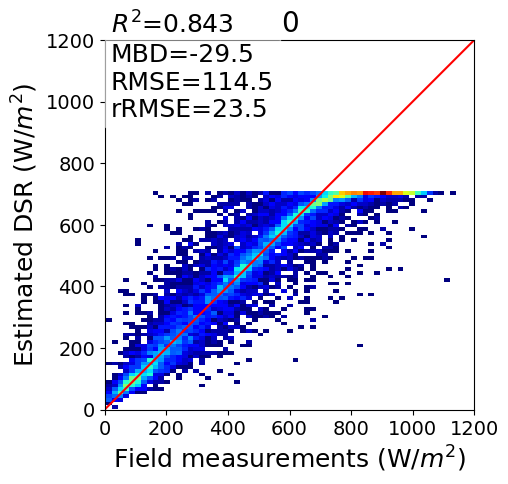

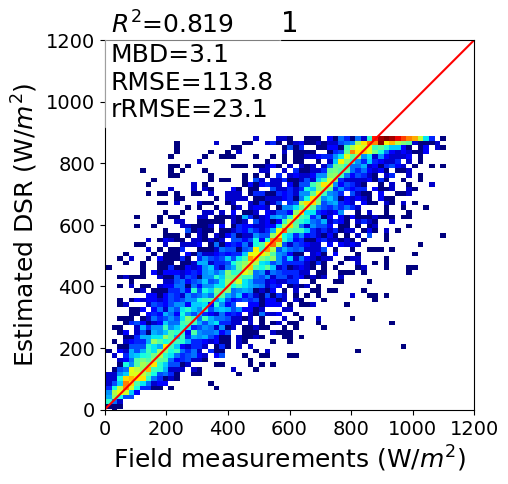

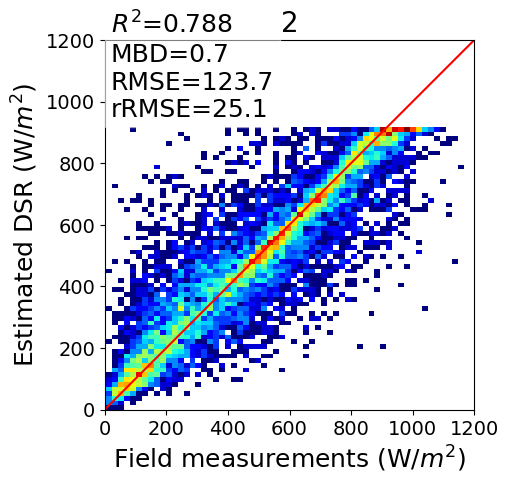

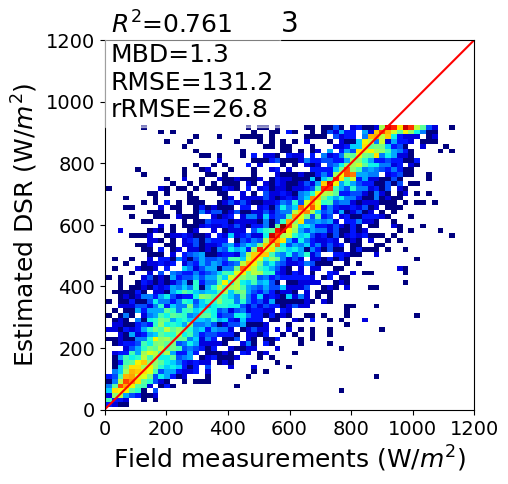

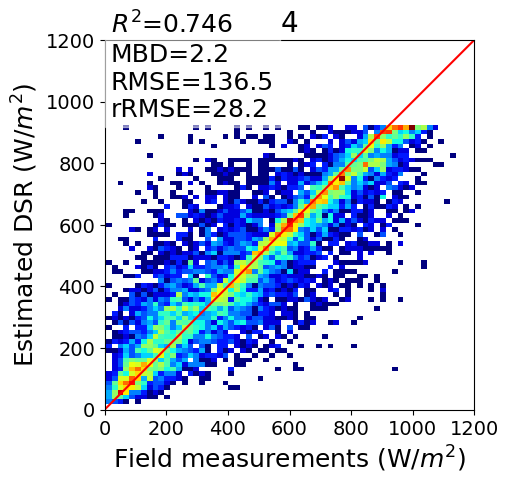

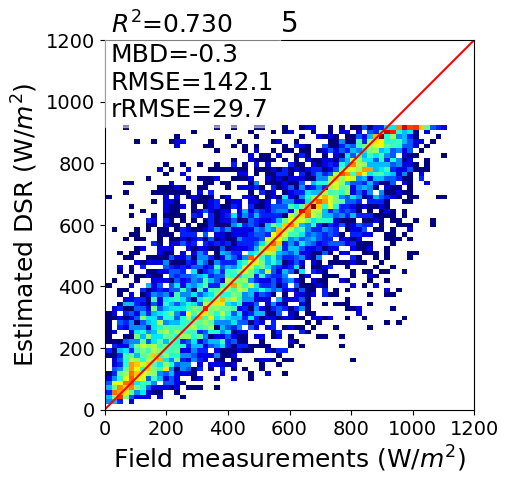

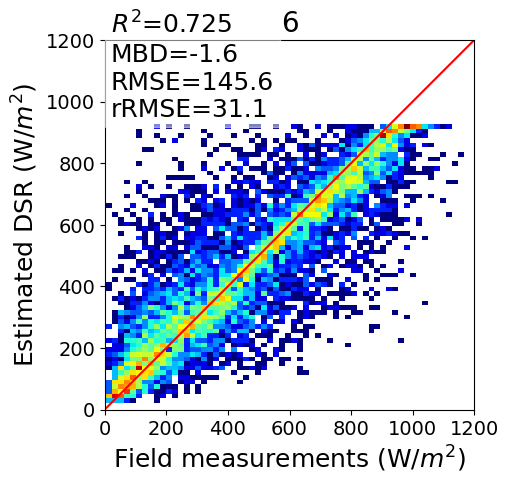

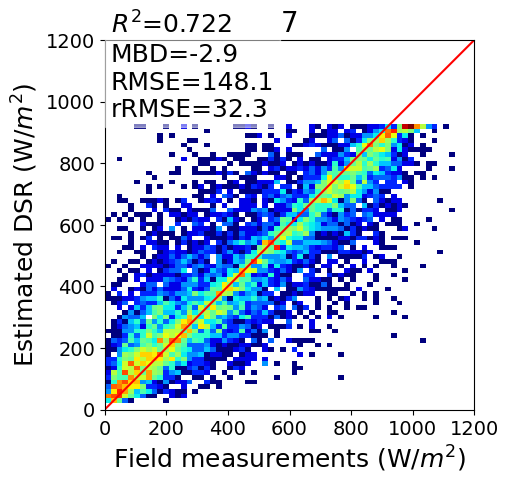

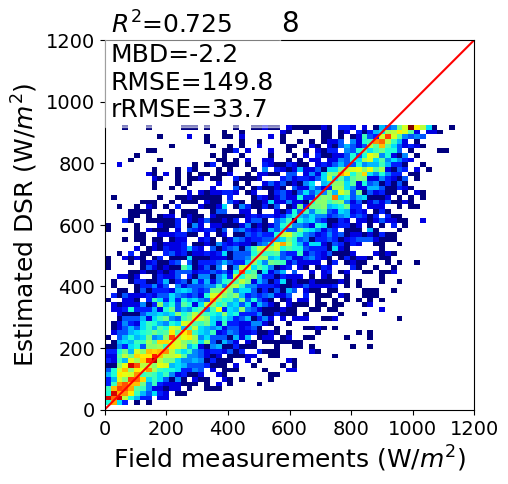

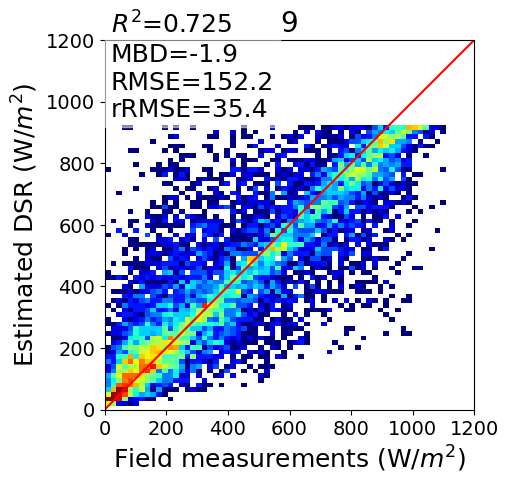

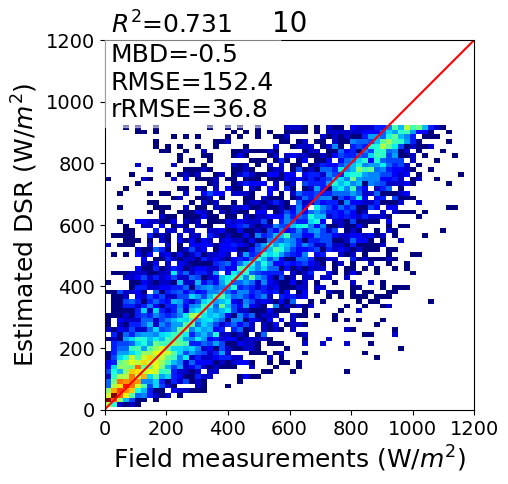

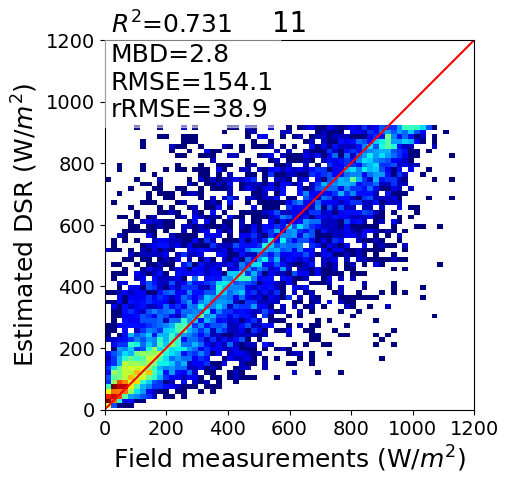

In [57]:

for i in range(12):
  p=predictions[:,i,0]
  y=y_test[:,i,0]

  dfp=pd.DataFrame()
  dfp['swin']=y
  dfp['predict']=p
  dfp=dfp.dropna()

  ax = plt.subplot(1,1,1)
  plt.title(str(i))
  denseScatter_dsr3h(dfp.swin.array,dfp.predict.array,str(i),ax)
  plt.show()